In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')
nvmlShutdown()

GPU0 Memory: 10701MB


# 导入必要的库
我们需要导入一个叫 captcha 的库来生成验证码。

我们生成验证码的字符由数字和几个运算符组成。

/usr/local/lib/python2.7/dist-packages/captcha/image.py

0123456789+-*=() 
18


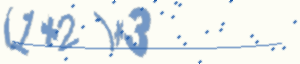

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
digits = string.digits
operators = '+-*='
characters = digits + operators + '() '
print(characters)

width, height, n_len, n_class = 300, 64, 11, len(characters) + 1
print(n_class)

from IPython.display import display
generator = ImageCaptcha(width=width, height=height, font_sizes=range(35, 56), 
                         fonts=['fonts/%s'%x for x in os.listdir('fonts') if '.tt' in x])
display(generator.generate_image('(1+2)*3'))

# 生成混合运算字符串

In [ ]:
# def generate():
#     seq = ''
#     k = random.randint(0, 2)
    
#     if k == 1:
#         seq += '('
#     seq += random.choice(digits)
#     seq += random.choice(operators)
#     if k == 2:
#         seq += '('
#     seq += random.choice(digits)
#     if k == 1:
#         seq += ')'
#     seq += random.choice(operators)
#     seq += random.choice(digits)
#     if k == 2:
#         seq += ')'
    
#     return seq

# generate()

# 定义 CTC Loss

In [3]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 定义网络结构

In [4]:
from keras.layers import *
from keras.models import *
from make_parallel import make_parallel
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
print(conv_shape)
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
conv_shape1 = x.get_shape()
print('')
print('conv_shape1')
print(conv_shape1)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
conv_shape2 = x.get_shape()
print('')
print('conv_shape2')
print(conv_shape2)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

#不使用并行处理方法
#base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model.output, labels, input_length, label_length])

model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

(?, 34, 4, 128)

conv_shape1
(?, 34, 512)

conv_shape2
(?, 34, 128)


d:\ProgramData\Anaconda3\envs\captcha_demo\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


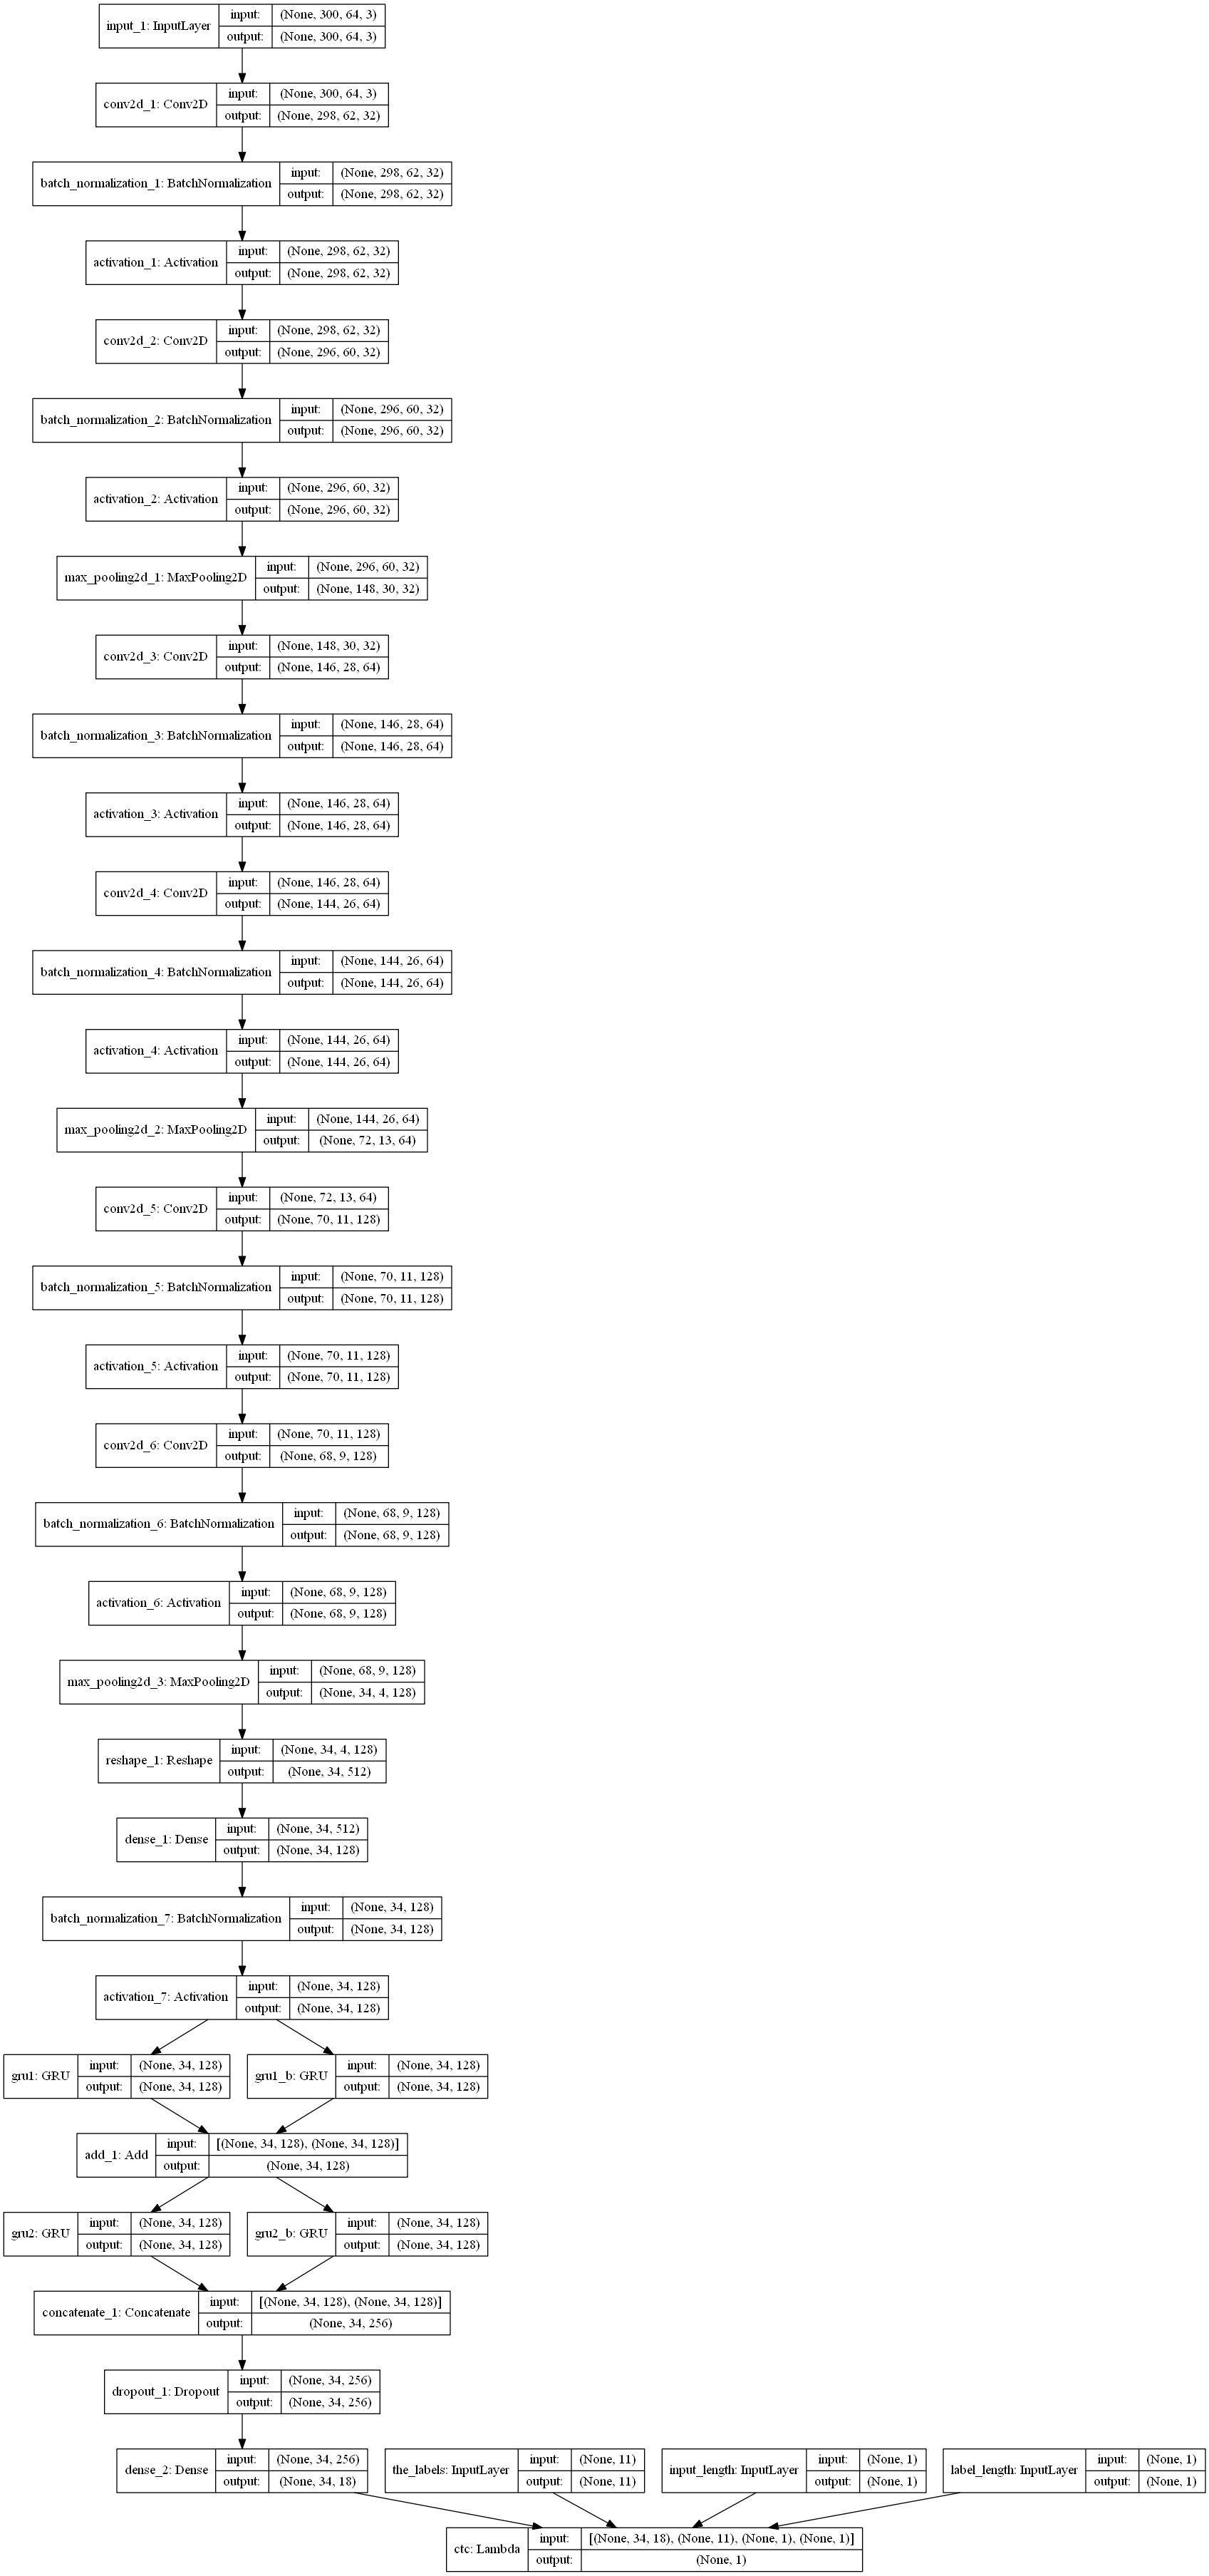

In [5]:
#from keras.utils.visualize_util import plot
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

#plot(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 定义数据生成器

In [6]:
import cv2
import random
from tqdm import tqdm

class TextImageGenerator:
    def __init__(self, rootpath, img_dirpath, label, img_w, img_h, batch_size, downsample_factor, max_text_len):
        self.rootpath = rootpath # 文件根目录
        self.img_dirpath = img_dirpath
        self.label = label
        self.img_w = img_w
        self.img_h = img_h
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = max_text_len
        self.n = len(self.img_dirpath) # 图片数量
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []

    def build_data(self):
        for i, img_file in enumerate(tqdm(self.img_dirpath)):
            img = cv2.imread(self.rootpath + img_file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0
            self.imgs[i, :, :] = img
            self.texts.append(self.label[i])
        print(self.n, " Image Loading finish...")

    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.empty([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                labels = text_to_labels(text)
                Y_data[i, 0:len(labels)] = labels
                Y_data[i, len(labels):13] = 16
                label_length[i] = len(text)

            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
data_csv = pd.read_csv(u'G:\my_code\python\mathematical_expression_recognition\Mathematical_Expression_Recognition_train\\train.csv')
img_dirpath = data_csv['filename'].tolist()
label = data_csv['label'].tolist()
X_data, X_valid, y_data, y_valid = train_test_split(img_dirpath, label, test_size=10000, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10000, random_state=17)

In [20]:
rootpath=u'G:\my_code\python\mathematical_expression_recognition\Mathematical_Expression_Recognition_train\train\\'

batch_size = 256
downsample_factor = 4
max_text_len = 12

data_train = TextImageGenerator(rootpath, X_train, y_train, width, height, batch_size, downsample_factor, max_text_len)
data_train.build_data()

MemoryError: 